# Location and Time Series Access Using Polytope Feature Extraction

This notebook showcases efficient geo-location and time series access using polytope feature extraction. By leveraging this feature, we significantly reduce data retrieval from storage, optimizing workflows and resource utilization.

## Installation
See instruction in [Polytope installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1)

**Configuring Access to Polytope**

In [ ]:
import os
import dataclasses as dc
from meteodatalab import mars

#ECMWF polytope credentials
# leave empty for ICON-CSCS polytope
os.environ["POLYTOPE_USER_KEY"] = ""
os.environ["POLYTOPE_USER_EMAIL"] = ""

#ICON-CSCS polytope credentials
# leave empty for ecmwf polytope
os.environ["POLYTOPE_USER_KEY"] = "xxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
os.environ["POLYTOPE_LOG_LEVEL"] = "INFO"

**Selecting geo-location point of interest in rotated lat-lon grid (ICON-CH1 & ICON-CH2) as well as in geographical coordinates**

In [2]:
import cartopy.crs as ccrs
import numpy as np
#zrh_gc = (8.55,47.3367)
rot_coord = (0,0)


# South pole rotation of lon=10, latitude=-43
rotated_crs = ccrs.RotatedPole(
    pole_longitude=190, pole_latitude=43
)

# Convert a point from geographic to rotated coordinates
original_crs = ccrs.PlateCarree()
(x,y) = original_crs.transform_point(*rot_coord, rotated_crs)
rotated_point = mars.Point(*rot_coord[::-1])
geo_point = mars.Point(y,x)


**Selecting date,time of the forecast**

In [ ]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time


**Querying the data** <br>
The `feature` attribute tells polytope to extract **only the relevant data at the given point**.
The amount of data that is retrieved from storage is signficantly reduced.

In [4]:
request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH2_EPS,
    levtype=mars.LevType.SURFACE,
    number=1,
    feature=mars.TimeseriesFeature(
        points=[rotated_point],
        range=mars.Range(start=0, end=120),
        time_axis="step",
    )
)

In [ ]:
import earthkit.data as ekd
ds = ekd.from_source(
    "polytope",
    "mchgj",
    request.to_polytope(),
    stream=False
).to_xarray()

**Plot the results**

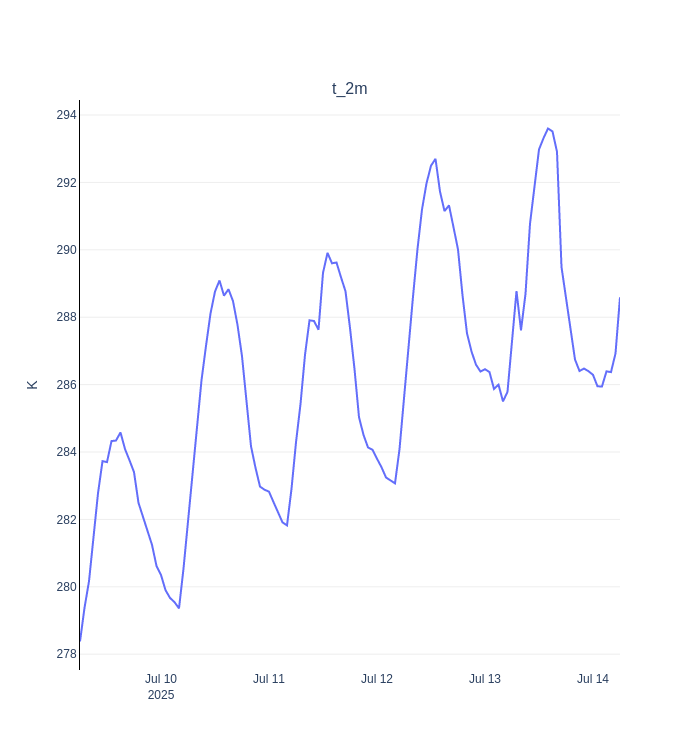

In [6]:
from earthkit.plots.interactive import Chart

chart = Chart()
chart.line(ds)
chart.show(renderer="png")  # Replace with chart.show() in an interactive session!



We can also query the entire ensemble data for the same geo-location. 

For ICON-CH2-EPS

In [ ]:
import xarray as xr
ds_mems = []
for num in range(1,21):
    req = dc.replace(request, number=str(num), model=mars.Model.ICON_CH2_EPS, feature=mars.TimeseriesFeature(
        points=[rotated_point],
        range=mars.Range(start=0, end=120),
        time_axis="step",
    ))
    print(req.to_polytope())
    ds_mems.append(ekd.from_source(
      "polytope",
      "mchgj",
      req.to_polytope(),
      stream=False
    ).to_xarray())

ds_ch2 = xr.concat(ds_mems, dim='number')

    

For ICON-CH1-EPS

In [ ]:
import xarray as xr
ds_mems = []
for num in range(1,11):
    req = dc.replace(request, number=str(num), model=mars.Model.ICON_CH1_EPS, feature=mars.TimeseriesFeature(
        points=[rotated_point],
        range=mars.Range(start=0, end=33),
        time_axis="step",
    ))
    print(req.to_polytope())
    ds_mems.append(ekd.from_source(
      "polytope",
      "mchgj",
      req.to_polytope(),
      stream=False
    ).to_xarray())

ds_ch1 = xr.concat(ds_mems, dim='number')

We can also request the same data for IFS using the polytope of ecmwf

In [ ]:
import os

os.environ["POLYTOPE_USER_KEY"] = "xxxx"
os.environ["POLYTOPE_USER_EMAIL"] = "xxx.yyy@domain.ch"
os.environ["POLYTOPE_ADDRESS"] = "polytope.ecmwf.int"

In [ ]:

request = {
    "class": "od",
    "stream" : "enfo",
    "type" : "pf",
    "date" : -1,
    "time" : "0000",
    "levtype" : "sfc",
    "expver" : "0001",
    "domain" : "g",
    "param" : "167",
    "number" : "1/to/50",
    "step": "0/to/160",
    "feature" : {
        "type" : "timeseries",
        "points": [[float(round(geo_point.lon,2)),float(round(geo_point.lat))]],
        "axes": "step",
    },
}

ds_ifs = ekd.from_source(
    "polytope",
    "ecmwf-mars",
    request,
    stream=False,
    address='polytope.ecmwf.int',
)

**Plotting ensemble members of timeseries**

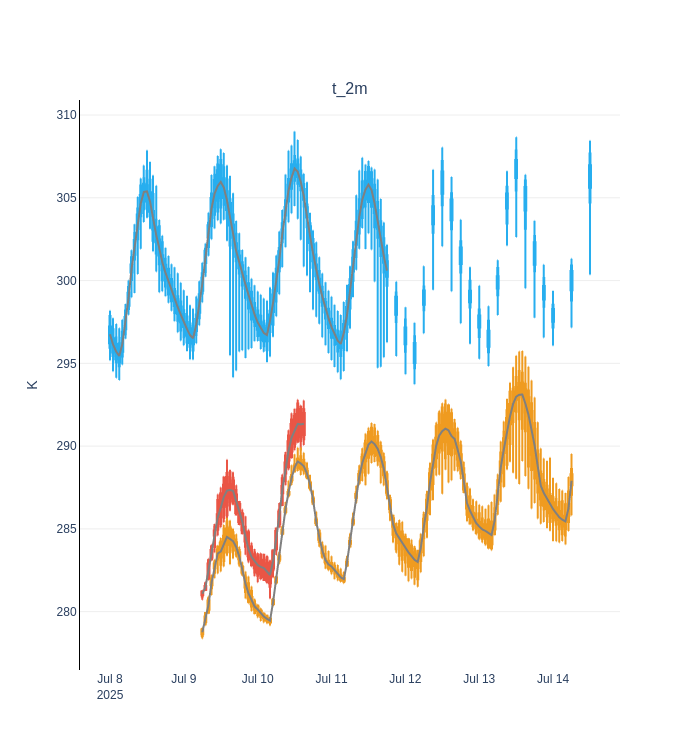

In [11]:
from earthkit.plots.interactive import Chart


TIME_FREQUENCY = "1h"
QUANTILES = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

chart = Chart()
chart.box(ds_ch1, quantiles=QUANTILES, line_color='#ea5545' )
chart.line(ds_ch1,aggregation='mean', line_color='grey', time_frequency=TIME_FREQUENCY)
chart.box(ds_ch2, quantiles=QUANTILES, line_color="#ef9b20")
chart.line(ds_ch2,aggregation='mean', line_color='grey', time_frequency=TIME_FREQUENCY)
chart.box(ds_ifs, quantiles=QUANTILES, line_color="#27aeef")
chart.line(ds_ifs,aggregation='mean', line_color='grey', time_frequency=TIME_FREQUENCY)

chart.show(renderer="png")  # Replace with chart.show() in an interactive session!
